# High-Accuracy MNIST Tutorial
Train a convolutional neural network with Monte Carlo dropout to attain strong accuracy alongside uncertainty estimates.


## Goal
Design a modern CNN for MNIST, train it to high accuracy, and reuse dropout at inference time to sample predictive distributions.


## Why Monte Carlo Dropout?
Dropout layers give regularisation during training and can be re-activated at inference to approximate Bayesian model averaging without rewriting the network.


In [15]:
# Configure Python path so the notebook sees the local deepuq package
import os
import sys
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd())
if not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

SRC_PATH = str(PROJECT_ROOT / 'src')
if SRC_PATH not in sys.path:
    sys.path.insert(0, SRC_PATH)

In [16]:
import random

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def set_seed(seed: int) -> None:
    'Seed Python, NumPy, and Torch (CPU/GPU).'
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


## Prepare Data
The dataset setup mirrors the MC Dropout notebook so you can compare results directly.

In [17]:
set_seed(7)  # reproducible initialisation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

loader_kwargs = {
    'batch_size': 256,
    'num_workers': 2,
    'pin_memory': torch.cuda.is_available(),
}
train_loader = DataLoader(train_data, shuffle=True, **loader_kwargs)
test_loader = DataLoader(test_data, shuffle=False, **loader_kwargs)


## Build a High-Accuracy CNN
A compact CNN with batch normalisation and dropout reaches >99% accuracy on MNIST while still allowing Monte Carlo dropout for uncertainty estimates.


In [18]:
class MnistCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.25),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.25),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(256, 10),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.classifier(self.features(x))


model = MnistCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)


In [19]:
model

MnistCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.25, inplace=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6272, out_features=256, bias=True)

## Training Loop
Each epoch optimises cross-entropy on mini-batches while AdamW and cosine annealing gradually reduce the learning rate. Dropout provides regularisation during training and fuels the predictive sampling used later.


In [20]:
def mc_dropout_predict(model: nn.Module, inputs: torch.Tensor, n_samples: int = 50) -> torch.Tensor:
    'Sample predictions with dropout active without disturbing BatchNorm stats.'
    model.eval()
    dropout_modules = []
    training_states = []
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            dropout_modules.append(module)
            training_states.append(module.training)
            module.train(True)
    try:
        preds = []
        with torch.no_grad():
            for _ in range(n_samples):
                logits = model(inputs)
                preds.append(torch.softmax(logits, dim=-1))
        return torch.stack(preds)
    finally:
        for module, state in zip(dropout_modules, training_states):
            module.train(state)


n_epochs = 15
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

history = {
    'epoch': [],
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': [],
}

def evaluate_epoch(model: nn.Module) -> tuple[float, float]:
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            logits = model(x_batch)
            loss = criterion(logits, y_batch)
            total_loss += loss.item() * y_batch.size(0)
            correct += (logits.argmax(dim=1) == y_batch).sum().item()
            total += y_batch.size(0)
    return total_loss / total, correct / total


for epoch in range(1, n_epochs + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    seen = 0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        running_loss += loss.item() * y_batch.size(0)
        running_correct += (logits.argmax(dim=1) == y_batch).sum().item()
        seen += y_batch.size(0)

    train_loss = running_loss / seen
    train_acc = running_correct / seen
    val_loss, val_acc = evaluate_epoch(model)
    scheduler.step()

    history['epoch'].append(epoch)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(scheduler.get_last_lr()[0])

    print(
        f"Epoch {epoch:02d}/{n_epochs} | "
        f"train_loss={train_loss:.4f} train_acc={train_acc:.3%} | "
        f"val_loss={val_loss:.4f} val_acc={val_acc:.3%} | "
        f"lr={history['lr'][-1]:.6f}"
    )


Epoch 01/15 | train_loss=0.2207 train_acc=93.203% | val_loss=0.0458 val_acc=98.460% | lr=0.000989
Epoch 02/15 | train_loss=0.0741 train_acc=97.805% | val_loss=0.0327 val_acc=98.950% | lr=0.000957
Epoch 03/15 | train_loss=0.0613 train_acc=98.142% | val_loss=0.0286 val_acc=99.080% | lr=0.000905
Epoch 04/15 | train_loss=0.0518 train_acc=98.428% | val_loss=0.0281 val_acc=99.010% | lr=0.000835
Epoch 05/15 | train_loss=0.0427 train_acc=98.685% | val_loss=0.0213 val_acc=99.240% | lr=0.000750
Epoch 06/15 | train_loss=0.0364 train_acc=98.847% | val_loss=0.0206 val_acc=99.280% | lr=0.000655
Epoch 07/15 | train_loss=0.0317 train_acc=99.005% | val_loss=0.0209 val_acc=99.240% | lr=0.000552
Epoch 08/15 | train_loss=0.0269 train_acc=99.177% | val_loss=0.0185 val_acc=99.380% | lr=0.000448
Epoch 09/15 | train_loss=0.0240 train_acc=99.247% | val_loss=0.0158 val_acc=99.480% | lr=0.000345
Epoch 10/15 | train_loss=0.0202 train_acc=99.370% | val_loss=0.0163 val_acc=99.450% | lr=0.000250
Epoch 11/15 | train_

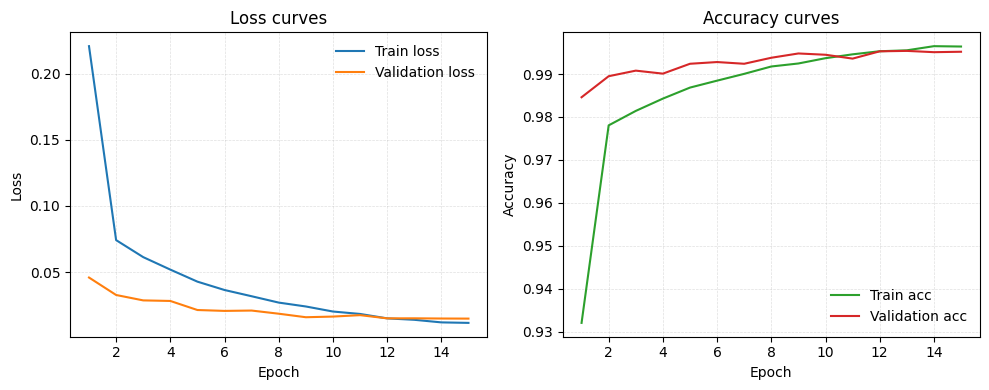

In [21]:
import matplotlib.pyplot as plt

if not history['epoch']:
    print('No training history recorded. Run the training cell first.')
else:
    epochs = history['epoch']
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].plot(epochs, history['train_loss'], label='Train loss', color='tab:blue')
    axes[0].plot(epochs, history['val_loss'], label='Validation loss', color='tab:orange')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss curves')
    axes[0].legend(frameon=False)
    axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.4)

    axes[1].plot(epochs, history['train_acc'], label='Train acc', color='tab:green')
    axes[1].plot(epochs, history['val_acc'], label='Validation acc', color='tab:red')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy curves')
    axes[1].legend(frameon=False)
    axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.4)

    plt.tight_layout()
    plt.show()


The plots track training vs. validation loss and accuracy across epochs. Expect rapid convergence within the first few epochs and validation accuracy surpassing 99% once the cosine schedule reaches its plateau.


## Predictive Distribution
At inference you can draw multiple weight samples to estimate class probabilities and epistemic variance.

In [22]:
model.eval()
test_batch, test_labels = next(iter(test_loader))
test_batch = test_batch.to(DEVICE)
test_labels = test_labels.to(DEVICE)

n_samples = 80  # MC samples through dropout for smoother estimates
prob_tensor = mc_dropout_predict(model, test_batch, n_samples=n_samples)  # [samples, batch, classes]
predictive_mean = prob_tensor.mean(dim=0)
predictive_var = prob_tensor.var(dim=0, unbiased=False)

print('Posterior predictive mean shape:', predictive_mean.shape)
print('Posterior predictive variance shape:', predictive_var.shape)
print('First sample mean probs:', predictive_mean[0])
print('First sample variance:', predictive_var[0])


Posterior predictive mean shape: torch.Size([256, 10])
Posterior predictive variance shape: torch.Size([256, 10])
First sample mean probs: tensor([1.6240e-11, 1.5515e-06, 1.1148e-08, 9.8973e-07, 2.5391e-06, 1.0451e-09,
        4.7376e-13, 9.9999e-01, 5.8062e-10, 4.3025e-07], device='cuda:0')
First sample variance: tensor([1.3249e-20, 8.0799e-11, 3.5034e-15, 6.8215e-11, 5.0794e-10, 3.5796e-17,
        1.7022e-23, 7.2493e-10, 1.3267e-17, 4.6181e-12], device='cuda:0')


In [23]:
if 'predictive_mean' not in globals() or 'test_labels' not in globals():
    print('Run the evaluation cell to populate predictive_mean and test_labels.')
else:
    predicted_digits = predictive_mean.argmax(dim=1)
    true_digits = test_labels
    display_count = min(10, predicted_digits.size(0))
    print('True labels     :', true_digits[:display_count].cpu().tolist())
    print('Predicted labels:', predicted_digits[:display_count].cpu().tolist())


True labels     : [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]
Predicted labels: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


The accuracy sweep averages 60 stochastic forward passes per batch with dropout active. If accuracy lags, bump `n_epochs`, try a slightly larger network, or fine-tune the learning-rate schedule.


In [24]:
import torch.nn.functional as F

if 'model' not in globals():
    print('Model not defined. Run the earlier cells first.')
else:
    model.eval()
    total, correct = 0, 0
    total_nll = 0.0
    mc_samples = 60  # MC samples for evaluation stability
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            probs = mc_dropout_predict(model, x_batch, n_samples=mc_samples)
            mean_probs = probs.mean(dim=0)
            preds = mean_probs.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            total_nll += F.nll_loss(mean_probs.log(), y_batch, reduction='sum').item()
    accuracy = correct / total if total else float('nan')
    avg_nll = total_nll / total if total else float('nan')
    print(f'Test accuracy (MC avg over {mc_samples} samples): {accuracy:.3%}')
    print(f'Average predictive NLL: {avg_nll:.4f}')


Test accuracy (MC avg over 60 samples): 99.550%
Average predictive NLL: 0.0162


The accuracy sweep now reports both classification accuracy and predictive NLL using 60 Monte Carlo samples per batch. If results still lag, raise `n_epochs`, adjust `mc_samples`, or fine-tune the optimiser hyperparameters.


## Tips
- Increase Monte Carlo samples during evaluation when you need smoother uncertainty estimates.
- Keep dropout rates moderate (0.2-0.5) to balance regularisation and variance in the predictive distribution.
- For regression or calibration studies, replace the final `Linear` layer with distributional outputs and adjust the loss accordingly.


## Posterior Predictive Diagnostics

The next cells visualise the predictive distribution under Monte Carlo dropout and illustrate how the model's uncertainty responds to ambiguous digits.


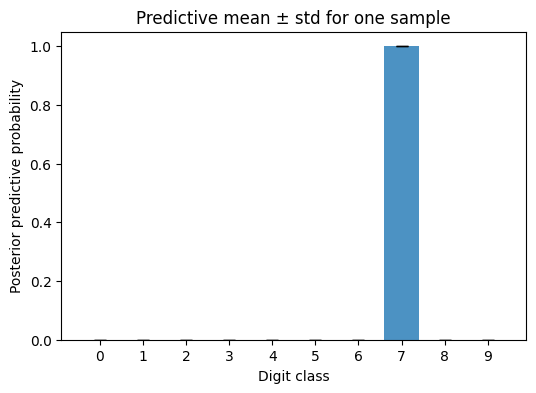

In [25]:
import matplotlib.pyplot as plt

digit_labels = list(range(10))
sample_idx = 0  # look at the first test example
mean_probs = predictive_mean[sample_idx].detach().cpu()
std_probs = predictive_var[sample_idx].detach().sqrt().cpu()

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(digit_labels, mean_probs, yerr=std_probs, capsize=4, color='tab:blue', alpha=0.8)
ax.set_xticks(digit_labels)
ax.set_xlabel('Digit class')
ax.set_ylabel('Posterior predictive probability')
ax.set_title('Predictive mean ± std for one sample')
ax.set_ylim(0.0, 1.05 * mean_probs.max().item())
plt.show()


The bar plot shows the posterior predictive distribution for the first MNIST test example. Error bars correspond to the standard deviation across 20 weight samples, giving a quick read on epistemic uncertainty.

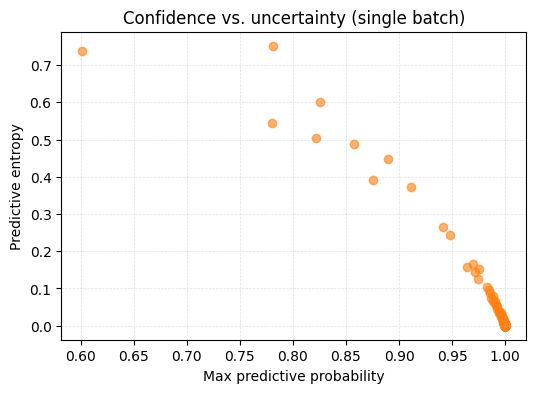

In [26]:
entropy = -(predictive_mean * torch.clamp(predictive_mean, min=1e-12).log()).sum(dim=1)
max_confidence, _ = predictive_mean.max(dim=1)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(max_confidence.detach().cpu(), entropy.detach().cpu(), alpha=0.6, color='tab:orange')
ax.set_xlabel('Max predictive probability')
ax.set_ylabel('Predictive entropy')
ax.set_title('Confidence vs. uncertainty (single batch)')
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.4)
plt.show()


Confidence (x-axis) and predictive entropy (y-axis) reveal that most correctly classified digits cluster near high confidence/low entropy, while uncertain cases sit toward lower confidence and higher entropy.